In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =\
["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

%cd ..

/kaggle


In [2]:
all_filenames = []
flowers = []
flower_classes = [0,1,2,3,4]
dict_flowers = {}
for flower_folder in os.listdir("./input/flowers-recognition/flowers/"):
    if flower_folder!='.DS_Store':
        all_filenames.append(os.listdir("./input/flowers-recognition/flowers/"+flower_folder))
        flowers.append(flower_folder)

for i, flower_type in enumerate(flowers):
    #print(i, flower_type)
    all_filenames[i] = [flower_type+'/' + item for item in all_filenames[i]]

#check if .DS_store file is in list, this causes errors
for folder in all_filenames:
    for i,filename in enumerate(folder):
        if '.DS_Store' in filename:
            print(folder[i])
            folder.remove(filename)

#print(all_filenames)
print(flowers)

dict_flowers["flower"] = all_filenames
dict_flowers["class_id"] = flower_classes

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [3]:
df = pd.DataFrame.from_dict(dict_flowers)
df = df.explode('flower').reset_index(drop=True)

print(len(df))
df.head()

4317


,flower,class_id
0,dandelion/34578947551_863af3acb3_n.jpg,0
1,dandelion/2625836599_03e192266f.jpg,0
2,dandelion/16242239484_51286673af.jpg,0
3,dandelion/5716633491_55e6f02645_n.jpg,0
4,dandelion/34697163155_5dc2571f23_n.jpg,0


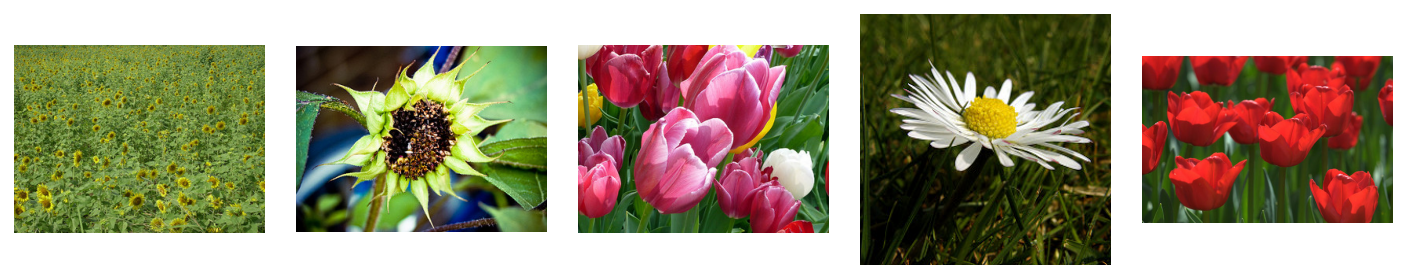

In [4]:
from PIL import Image

plt.figure(figsize=(10,10))
for i, file in enumerate(df['flower'].sample(n=5, random_state=1)):
    if i <5:
        img = Image.open("./input/flowers-recognition/flowers/"+file)
        ax = plt.subplot(1,5,i+1)
        ax.imshow(img)
        #ax.set_title(file, size=10)
        plt.axis('off')
    else:
        break
plt.tight_layout()



Preprocess images to tensors

In [5]:
train_x =[]
PATH = "./input/flowers-recognition/flowers/"
for i in tqdm(df.flower):
    img = Image.open(PATH+i)       # reading image
    img = img.resize((50,50))     # reasizing image
    train_x.append(np.array(img)) # saving image as array to train

train_y = np.array(df.class_id)
train_x = np.array(train_x)
print(train_x.shape)
print(train_y.shape)

100%|██████████| 4317/4317 [00:26<00:00, 160.74it/s]

(4317, 50, 50, 3)
(4317,)


Preprocess Test set

In [6]:
## Normalization
xtrain = train_x/255
#xtest = test_x/255

In [7]:
import tensorflow.keras as keras

ytrain = keras.utils.to_categorical(train_y)
#print(ytrain)
#ytest = keras.utils.to_categorical(test_y)

In [8]:
Xtrain, Xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, random_state=RANDOM_SEED)
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, test_size=0.05, random_state=RANDOM_SEED)

print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)
print(ytrain.shape)
print(yval.shape)
print(ytest.shape)

(3453, 50, 50, 3)
(820, 50, 50, 3)
(44, 50, 50, 3)
(3453, 5)
(820, 5)
(44, 5)


PYTORCH MODEL

KERAS MODEL

In [9]:
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten

model = keras.models.Sequential()
model.add(Conv2D(filters=32, kernel_size= (3,3), strides=2, activation='relu', padding='same', input_shape=(50,50,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=2, activation='relu', padding='same'))
model.add(MaxPool2D((2,2), padding='valid'))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same'))
model.add(MaxPool2D((2,2), padding='valid'))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(ytrain[0]), activation='softmax')) #num classes

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         36992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

2022-02-18 13:29:13.390714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 13:29:13.391697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 13:29:13.392445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 13:29:13.393323: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
from keras.applications.vgg16 import VGG16
model_pre = VGG16(include_top=False, input_shape=(50,50,3))
model = keras.models.Sequential()
model.add(model_pre)
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(ytrain[0]), activation='softmax')) #num classes

print(model.summary())

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                25650     
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 105       
Total params: 14,741,463
Trainable params: 14,741,463
N

In [11]:
# Compiling the CNN model
model.compile(optimizer='sgd',
             loss='categorical_crossentropy',
             metrics = ['accuracy'])

In [12]:
## Fitting the model, with early stopping callback

earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights =True)

model_history = model.fit(Xtrain,ytrain, epochs=50,
                         validation_data=(Xval,yval), batch_size=16, callbacks = earlystop_cb)

2022-02-18 13:29:19.937523: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-02-18 13:29:21.449923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


216/216 [==============================] - 12s 22ms/step - loss: 1.4050 - accuracy: 0.3921 - val_loss: 1.1674 - val_accuracy: 0.5671
Epoch 2/50
216/216 [==============================] - 4s 20ms/step - loss: 1.1103 - accuracy: 0.5656 - val_loss: 0.9822 - val_accuracy: 0.6341
Epoch 3/50
216/216 [==============================] - 4s 19ms/step - loss: 0.9312 - accuracy: 0.6507 - val_loss: 0.6394 - val_accuracy: 0.7854
Epoch 4/50
216/216 [==============================] - 4s 20ms/step - loss: 0.9439 - accuracy: 0.6429 - val_loss: 0.9903 - val_accuracy: 0.6183
Epoch 5/50
216/216 [==============================] - 4s 19ms/step - loss: 0.7998 - accuracy: 0.7133 - val_loss: 0.7151 - val_accuracy: 0.7476
Epoch 6/50
216/216 [==============================] - 4s 19ms/step - loss: 0.7115 - accuracy: 0.7538 - val_loss: 0.6307 - val_accuracy: 0.7793
Epoch 7/50
216/216 [==============================] - 5s 22ms/step - loss: 0.6365 - accuracy: 0.7816 - val_loss: 1.0059 - val_accuracy: 0.6622
Epoch 8/5

TEST MODEL

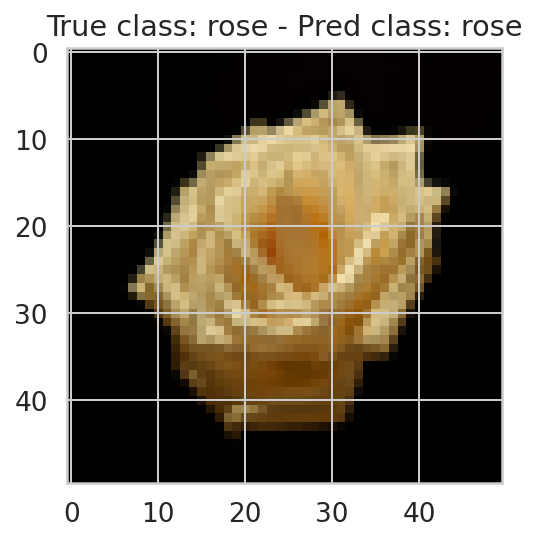

Accuracy is: 77.27272727272727


In [13]:
y_pred = model.predict(Xtest)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(ytest)):
    test.append(np.argmax(ytest[i]))


test_im = 10
from matplotlib import pyplot as plt
%matplotlib inline 

plt.imshow(Xtest[test_im], interpolation='nearest')
plt.title("True class: " + flowers[test[test_im]] + " - Pred class: " + flowers[pred[test_im]])
plt.show()

#print(pred,test)
    
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)